### Web Scraping and Performance evaluation of Text Classification Algortihms

In [240]:
# import the required libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

#### The objective of this assignment is to scrape consumer reviews from a set of web-pages and to evaluate the performance of text classification algorithms on the data.

#### Task 1: 
Select three review categories of your choice. Scrape all reviews for each category and store them as three separate datasets. For each review, you should store the review text and a class label (i.e. whether the review is “positive” or “negative”).

I have selected three categories: restaurant, cafe and hotels to scrape consumer reviews and ratings. Then evaluate the performance of text classification algorithms on the data extracted from these categories.

Each category page has links for consumer reviews and ratings. First, retrieving all the href tags from the category page, second, extracting reviews and ratings from those links.

BeautifulSoup package is used for the web scraping. Scraping all the href tags which are inside anchor tags of page, and storing them in separate lists for each category.


In [241]:
homeurl = 'http://mlg.ucd.ie/modules/yalp/'
# Fetch Restaurants, cafe and hotel links.
res_url = 'http://mlg.ucd.ie/modules/yalp/restaurants_list.html'
res_urls = []
# Response object to get the webpage.
response = requests.get(res_url)

# Data contains the source code of the webpage.
data = response.text

# Parsing the source code
soup = BeautifulSoup(data, 'html.parser')
# Extract the URLs for all the restaurants
res_urls =[homeurl+ item.get("href") for item in soup.find_all("a")]
#print(res_urls)


cafe_url = 'http://mlg.ucd.ie/modules/yalp/cafes_list.html'
cafe_urls = []
# Response object to get the webpage.
response = requests.get(cafe_url)

# Data contains the source code of the webpage.
data = response.text

# Parsing the source code
soup = BeautifulSoup(data, 'html.parser')
# Extract the URLs for all the cafes
cafe_urls =[homeurl+ item.get("href") for item in soup.find_all("a")]


hotel_url = 'http://mlg.ucd.ie/modules/yalp/hotels_list.html'
hotel_urls = []
# Response object to get the webpage.
response = requests.get(hotel_url)

# Data contains the source code of the webpage.
data = response.text

# Parsing the source code
soup = BeautifulSoup(data, 'html.parser')
# Extract the URLs for all the cafes
hotel_urls =[homeurl+ item.get("href") for item in soup.find_all("a")]


#### Extracting the reviews and ratings for each category
The function reviewRatings is created to fetch the reviews and ratings from each category and store them in a list.
Each review has a star rating. For this assignment, we will assume that 1-star to 3-star reviews are “negative”, and 4-star to 5-star reviews are “positive”.

In [242]:
def reviewRatings (urls):
   
   # Stores the final reviews along with the ratings.
    reviews_ratings = []
    # List for the reviews.
    reviews_list = []
    # List for the ratings of each reviews.
    ratings_list = []
   
    for url in urls:
        if 'index' in url:
            pass
       
       # retrieve the data from the specified base url.
        data = requests.get(url)
       
       # scrape the contents of the web page
        review_scraper = BeautifulSoup(data.content,'html.parser')
       
       # extract a particular class inside a tag
        cat_reviews = review_scraper.find_all('p',{"class":"review-text"})
        for review in cat_reviews:
            reviews_list.append(review.text) # extracting only the text for the review
           
        # Ratings exists in alt tag of the img tags.
        ratings = review_scraper.find_all('img',alt=True)    
       
        for rating in ratings:
            # if rating is less than 3: The review will be Negative.
            if int(rating.get('alt')[0])<=3:
                ratings_list.append('negative')
           
           # if rating is greater than 3: The review will be Positive.
            else:
                ratings_list.append('positive')
      # Dictionary of Reviews and Ratings
        dict_res = {'Reviews': reviews_list,'Label':ratings_list}
    
    # Convert the Reviews and Ratings to a dataframe and append to list
    reviews_ratings.append(pd.DataFrame(dict_res))
    
    return reviews_ratings

#### Store the reviews in csv files
Finally storing the reviews and ratings for each of three categories into three different csv files.

In [243]:
res_reviews_ratings = reviewRatings(res_urls) 
# Storing the reviews and their ratings in a csv.
res_result = pd.concat(res_reviews_ratings)   
res_result.to_csv('./ResReviews.csv', index = False)

cafe_reviews_ratings = reviewRatings(cafe_urls) 
# Storing the reviews and their ratings in a csv.
cafe_result = pd.concat(cafe_reviews_ratings)   
cafe_result.to_csv('./CafeReviews.csv', index = False)

hotel_reviews_ratings = reviewRatings(hotel_urls) 
# Storing the reviews and their ratings in a csv.
hotel_result = pd.concat(hotel_reviews_ratings)   
hotel_result.to_csv('./HotelReviews.csv', index = False)

In [244]:
# Read the Restaurants dataset
res_df = pd.read_csv('./ResReviews.csv')
print(res_df.head())

# Read the Cafe dataset
cafe_df = pd.read_csv('./CafeReviews.csv')
print(cafe_df.head())

# Read the Hotels dataset
hotel_df = pd.read_csv('./HotelReviews.csv')
print(hotel_df.head())

                                             Reviews     Label
0  My husband and I had a rare afternoon off so w...  negative
1  For years I thought this was only a wine store...  positive
2  This place is so charming! I went with my husb...  positive
3  We have been wanting to try this place for a c...  positive
4  Decor looks ok but layout is too busy. Difficu...  negative
                                             Reviews     Label
0  Pros: Lots of items you would not expect from ...  positive
1  Best egg-tarts in town! There's really not muc...  positive
2  I've been to ABC Bakery a few times since I re...  negative
3  FYI, Closed Monday's New ownership for about 1...  negative
4  The inside may not look like much but they mak...  positive
                                             Reviews     Label
0  Melissa took us on a tour of Asia in the space...  positive
1  With a group of seven of us visiting Montreal ...  positive
2  Melissa is a gem! My fiancé found her tour on ...  p

#### Task 2a) 
From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.

1. Normalizing the text into a single canonical form.
2. Lemmatize to convert the words to its base form, using lemmatization because stemming a word or sentence may result in words that are not actual words. Stems are created by removing the suffixes or prefixes used with a word.
3. Stop Word removal to remove useless words from the text to improve the search query processing time.
4. Term Frequency – Inverse Document Frequency to compute word frequencies to highlight which words are more interesting.

#### Normalization

In [245]:
# Removing the whitespaces and converting each review to lowercase.
res_df['Reviews'] = [item.strip().lower() for item in res_df['Reviews']]

cafe_df['Reviews'] = [item.strip().lower() for item in cafe_df['Reviews']]

hotel_df['Reviews'] = [item.strip().lower() for item in hotel_df['Reviews']]

#### Lemmatization

In [246]:
# WordNetLemmatizer() from nltk
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to lemmatize the text.
def lemmatizetext(text):
    return lemmatizer.lemmatize(text)

# Invoke the lemmatizetext function for Reviews of each dataframe.
res_df['Reviews'] = res_df.Reviews.apply(lemmatizetext)

cafe_df['Reviews'] = cafe_df.Reviews.apply(lemmatizetext)

hotel_df['Reviews'] = hotel_df.Reviews.apply(lemmatizetext)


#### TDF-IDF Vectorizer and stop word removal

Computing the TDF-IDF scores for the words in the reviews after removing the stop words to change the reviews into a numerical data representation. Storing these frequency scores and the ratings in a new data frame for each category.


In [247]:
# TF-IDF Vectorizer object to remove the stop words, fit and transform the reviews.
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,min_df=0.01,stop_words='english',use_idf=True)

tfidf_matrix = tfidf_vectorizer.fit_transform(res_df['Reviews'])
terms = tfidf_vectorizer.get_feature_names()

# Dataframe with column names as the features from the vectorised object.
resRevdf = pd.DataFrame(tfidf_matrix.todense(), columns = terms)
resRevdf['Label'] = res_df['Label']
print(resRevdf.shape)


tfidf_matrix = tfidf_vectorizer.fit_transform(cafe_df['Reviews'])
terms = tfidf_vectorizer.get_feature_names()

# Dataframe with column names as the features from the vectorised object.
cafeRevdf = pd.DataFrame(tfidf_matrix.todense(), columns = terms)
cafeRevdf['Label'] = cafe_df['Label']
print(cafeRevdf.shape)


tfidf_matrix = tfidf_vectorizer.fit_transform(hotel_df['Reviews'])
terms = tfidf_vectorizer.get_feature_names()

# Dataframe with column names as the features from the vectorised object.
hotelRevdf = pd.DataFrame(tfidf_matrix.todense(), columns = terms)
hotelRevdf['Label'] = hotel_df['Label']
print(hotelRevdf.shape)


(2000, 868)
(2000, 860)
(2000, 1003)


#### Task 2b)
Build a classification model to distinguish between “positive” and “negative” reviews using one of the following classifiers:
Naive Bayes, Logistic Regression, Random Forests

#### Using Cross Validation to determine which classifier has the best accuracy for each category
Cross Validation is a technique to measure the effectiveness of different machine learning models. Thus, using this technique here to assess the effectiveness of NaiveBaye's, Logistic Regression and RandomForest Classifer models.
1. Here we split the entire data randomly into k folds, k=10 in this case.
2. Then fitting the model using the K — 1 folds and validate the model using the remaining Kth fold.
3. Repeating this process until every K-fold serves as the test set. Then taking the average of the recorded accuracy scores. This average accuracy score will be the performance metric for each of the above mentioned model.

In [248]:
def cv_accuracy(df):

    model_d = {}

    model_d['rf'] = RandomForestClassifier(max_depth=2, random_state=0)
    model_d['mnb'] = MultinomialNB()
    model_d['logistic'] = LogisticRegression(max_iter=1000, solver = 'sag', random_state=0)

    scoring = {'accuracy': make_scorer(accuracy_score)}

    accuracy = []
    for m in model_d:
        cv_results = cross_validate(model_d[m],df.iloc[:,:-1], df.iloc[:,-1], cv= 10,scoring=scoring, return_train_score=False,
                                       verbose = 0, n_jobs = -1)
        accuracy.append(cv_results['test_accuracy'].mean())
        print("{} x CV {:22} Acc: {:.2f}".format(10, type(model_d[m]).__name__, cv_results['test_accuracy'].mean()))


    classifier = ['RandomForest', 'NaiveBayes', 'LogisticRegression']
    fig, ax = plt.subplots()

    bar1 = ax.barh(classifier, acc, color = ['Green'])

    plt.title('Title')
    plt.ylabel('Accuracy')
    plt.xlabel('Classifier')
    plt.show()

#### Determine the best classification model for the restaurants category
Using the cv_accuracy function above to find the most effective classifier for the restaurant dataset. We can see that Logistic Regression has the highest accuracy, therefore using Logistic Regression as the classifier for further classifying and evaluating the performance of the classifier model on the restaurant dataset.

10 x CV RandomForestClassifier Acc: 0.62
10 x CV MultinomialNB          Acc: 0.84
10 x CV LogisticRegression     Acc: 0.85


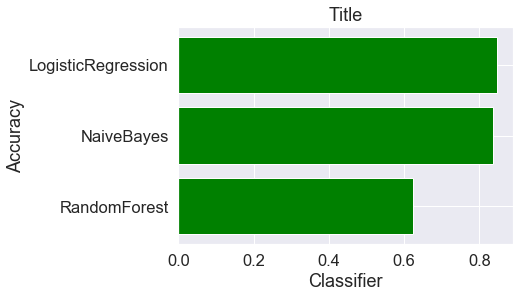

In [249]:
cv_accuracy(resRevdf)

#### Building a Logistic Regression classifier. Training the data and predicting the target.

In [250]:
# Splitting the dataset in training and testing dataset for Restaurant category.

X_resTrain, X_resTest,Y_resTrain, Y_resTest = train_test_split(resRevdf.iloc[:,:-1], resRevdf.iloc[:,-1], test_size = 0.3)

# Logistic Regression Classifier.
res_reg = LogisticRegression()

# Fitting the model
res_reg.fit(X_resTrain, Y_resTrain)

# Predicting the target for Restaurant category.
Y_res_pred = res_reg.predict(X_resTest)


#### Task 2c)
Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.

We can see from above that this is a binary classification problem where the target is positive or negative. Confusion matrix gives you a more complete picture of how your classifier is performing. The confusion matrix produces four outcomes – true positives, true negatives, false positives and false negatives. Accuracy can be misleading and sometimes it may be desirable to select a model with a lower accuracy because it has a greater predictive power on the problem. Therefore, confusion matrix is a better option as it gives insight into the predictions.

#### 2c.1 Evaluation strategy for the classification model for Restaurant category dataset

The confusion matrix gives us the total number of:
1. True Positive(TP): 187 correct predictions of positive reviews.
2. False Negative(FN): 71 positive reviews falsely identified as negative reviews.
3. False Positive(FP): 56 negative reviews incorrectly identified as positive reviews.
4. True Negative(TN): 321 negative reviews correctly identified.

We can see that FNs and FPs as quite low in number, that is when classifier falsely predicted the class labels. And the correct predictions TP and TN are quite high.Therefore, we can say the overall performance of the model is good. 

              precision    recall  f1-score   support

    positive       0.90      0.72      0.80       258
    negative       0.82      0.94      0.87       342

    accuracy                           0.85       600
   macro avg       0.86      0.83      0.84       600
weighted avg       0.85      0.85      0.84       600



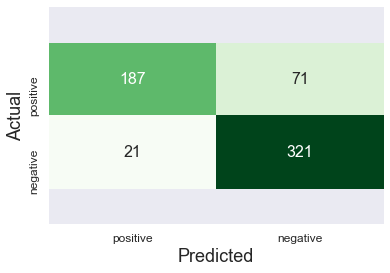

In [254]:
# Confusion matrix for the Restaurant dataset
cm = confusion_matrix(Y_resTest, Y_res_pred)
print(classification_report(Y_resTest, Y_res_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Determine the best classification model for the Cafe category
Using the cv_accuracy function above to find the most effective classifier for the cafe dataset. We can see that Logistic Regression has the highest accuracy, therefore using Logistic Regression as the classifier for further classifying and evaluating the performance of the classifier model on the cafe dataset.

10 x CV RandomForestClassifier Acc: 0.73
10 x CV MultinomialNB          Acc: 0.84
10 x CV LogisticRegression     Acc: 0.85


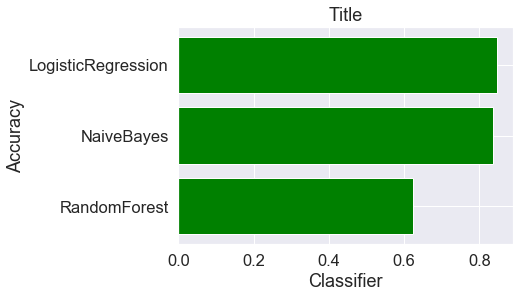

In [282]:
cv_accuracy(cafeRevdf)

#### Building a Logistic Regression classifier. Training the data and predicting the target.

In [255]:
# Splitting the dataset in training and testing dataset for cafe category.

X_cafeTrain, X_cafeTest,Y_cafeTrain, Y_cafeTest = train_test_split(cafeRevdf.iloc[:,:-1], cafeRevdf.iloc[:,-1], test_size = 0.3)

# Logistic Regression Classifier.
cafe_reg = LogisticRegression()

# Fitting the model
cafe_reg.fit(X_cafeTrain, Y_cafeTrain)

# Predicting the target for Cafe category.
Y_cafe_pred = cafe_reg.predict(X_cafeTest)

#### 2c.2 Evaluation strategy for the classification model for Cafe category dataset

The confusion matrix gives us the total number of:
1. True Positive(TP): 74 correct predictions of positive reviews.
2. False Negative(FN): 77 positive reviews falsely identified as negative reviews.
3. False Positive(FP): 17 negative reviews incorrectly identified as positive reviews.
4. True Negative(TN): 432 negative reviews correctly identified.

We can see that FNs and FPs as quite low in number, that is when classifier falsely predicted the class labels. And the correct predictions TP is lower, thus its f1-score is also lower, but TN is quite high.Therefore, we can say the overall performance of the model is good as the number of total correct predictions is high.

              precision    recall  f1-score   support

    positive       0.81      0.49      0.61       151
    negative       0.85      0.96      0.90       449

    accuracy                           0.84       600
   macro avg       0.83      0.73      0.76       600
weighted avg       0.84      0.84      0.83       600



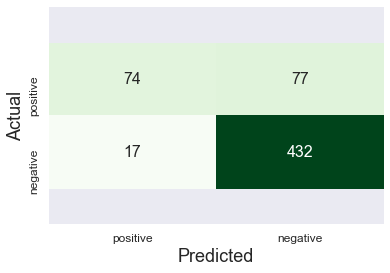

In [256]:
# Confusion matrix for the Cafe dataset
cm = confusion_matrix(Y_cafeTest, Y_cafe_pred)
print(classification_report(Y_cafeTest, Y_cafe_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Determine the best classification model for the Hotel category
Using the cv_accuracy function above to find the most effective classifier for the Hotel dataset. We can see that Logistic Regression has the highest accuracy, therefore using Logistic Regression as the classifier for further classifying and evaluating the performance of the classifier model on the Hotel dataset.

10 x CV RandomForestClassifier Acc: 0.64
10 x CV MultinomialNB          Acc: 0.88
10 x CV LogisticRegression     Acc: 0.89


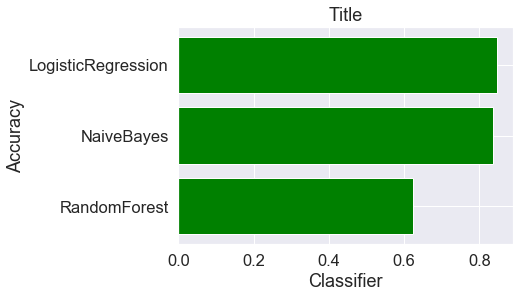

In [257]:
cv_accuracy(hotelRevdf)

#### Building a Logistic Regression classifier. Training the data and predicting the target.

In [258]:
# Splitting the dataset in training and testing dataset for Hotel category.

X_hotelTrain, X_hotelTest,Y_hotelTrain, Y_hotelTest = train_test_split(hotelRevdf.iloc[:,:-1], hotelRevdf.iloc[:,-1], test_size = 0.3)

# Logistic Regression Classifier.
hotel_reg = LogisticRegression()

# Fitting the model
hotel_reg.fit(X_hotelTrain, Y_hotelTrain)

# Predicting the target for Hotel category.
Y_hotel_pred = hotel_reg.predict(X_hotelTest)

#### 2c.3 Evaluation strategy for the classification model for Hotel category dataset

The confusion matrix gives us the total number of:
1. True Positive(TP): 207 correct predictions of positive reviews.
2. False Negative(FN): 40 positive reviews falsely identified as negative reviews.
3. False Positive(FP): 23 negative reviews incorrectly identified as positive reviews.
4. True Negative(TN): 330 negative reviews correctly identified.

We can see that FNs and FPs as quite low in number, that is when classifier falsely predicted the class labels. And the correct predictions TP and TN are quite high.Therefore, we can say the overall performance of the model is good.

              precision    recall  f1-score   support

    positive       0.90      0.84      0.87       247
    negative       0.89      0.93      0.91       353

    accuracy                           0.90       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.90      0.89       600



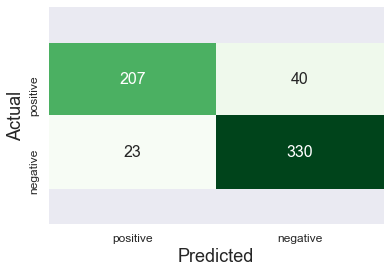

In [260]:
# Confusion matrix for the Hotel dataset
cm = confusion_matrix(Y_hotelTest, Y_hotel_pred)
print(classification_report(Y_hotelTest, Y_hotel_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Conclusion for Task 2
Logistic regression is a very powerful algorithm, even for very complex problems it may do a good job.
It is a widely used technique because it is very efficient, does not require too many computational resources, it’s highly interpretable, it doesn’t require input features to be scaled, it doesn’t require any tuning, it’s easy to regularize, and it outputs well-calibrated predicted probabilities.

#### Task 3

Evaluate the performance of each of your three classification models when applied to data from the other two selected categories

#### Train a classification model on the data from  Restaurant category

In [261]:
# Splitting the dataset in training and testing dataset.

X_resTrain, X_resTest,Y_resTrain, Y_resTest = train_test_split(resRevdf.iloc[:,:-1], resRevdf.iloc[:,-1], test_size = 0.3)

# Logistic Regression Classifier.
res_reg = LogisticRegression()

# Fitting the model
res_reg.fit(X_resTrain, Y_resTrain)

Y_hotelTest = hotelRevdf.iloc[:,-1]
Y_cafeTest = cafeRevdf.iloc[:,-1]


#### Reshaping both Cafe and Hotel dataset as per the Restaurant dataset

In [262]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,min_df=0.01,stop_words='english',use_idf=True)

Res = tfidf_vectorizer.fit_transform(res_df['Reviews'])
print(Res.shape)

Hotel = tfidf_vectorizer.transform(hotel_df['Reviews'])
print(Hotel.shape)

Cafe = tfidf_vectorizer.transform(cafe_df['Reviews'])
print(Cafe.shape)

(2000, 867)
(2000, 867)
(2000, 867)


#### Evaluate Hotels on the model built on Restaurants

              precision    recall  f1-score   support

    positive       0.75      0.87      0.81       824
    negative       0.90      0.80      0.85      1176

    accuracy                           0.83      2000
   macro avg       0.83      0.84      0.83      2000
weighted avg       0.84      0.83      0.83      2000



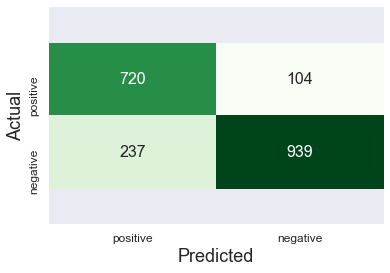

In [263]:
Y_hotel_pred = res_reg.predict(Hotel)
#print("Hotel Review Accuracy = %.2f" % accuracy_score(Y_hotelTest, Y_hotel_pred) )

# Confusion matrix for the Hotels dataset
cm = confusion_matrix(Y_hotelTest, Y_hotel_pred)
print(classification_report(Y_hotelTest, Y_hotel_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



#### Evaluate Cafe on the model built on Restaurants

              precision    recall  f1-score   support

    positive       0.76      0.74      0.75       538
    negative       0.90      0.91      0.91      1462

    accuracy                           0.87      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.87      0.87      0.87      2000



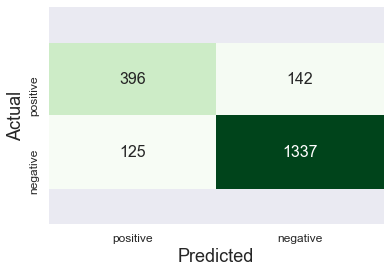

In [264]:
Y_cafe_pred = res_reg.predict(Cafe)
#print("Cafe Review Accuracy = %.2f" % accuracy_score(Y_cafeTest, Y_cafe_pred) )

# Confusion matrix for the Cafe dataset
cm = confusion_matrix(Y_cafeTest, Y_cafe_pred)
print(classification_report(Y_cafeTest, Y_cafe_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


#### Train a classification model on the data from  Cafe category

In [274]:
# Splitting the dataset in training and testing dataset.

X_cafeTrain, X_cafeTest, Y_cafeTrain, Y_cafeTest = train_test_split(cafeRevdf.iloc[:,:-1], cafeRevdf.iloc[:,-1], test_size = 0.3)

# Logistic Regression Classifier.
cafe_reg = LogisticRegression()

# Fitting the model
cafe_reg.fit(X_cafeTrain, Y_cafeTrain)

Y_hotelTest = hotelRevdf.iloc[:,-1]
Y_resTest = resRevdf.iloc[:,-1]

#### Reshaping both Restaurant and Hotel dataset as per the Cafe dataset

In [283]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,min_df=0.01,stop_words='english',use_idf=True)

Cafe = tfidf_vectorizer.fit_transform(cafe_df['Reviews'])
print(Cafe.shape)

Hotel = tfidf_vectorizer.transform(hotel_df['Reviews'])
print(Hotel.shape)

Res = tfidf_vectorizer.transform(res_df['Reviews'])
print(Res.shape)

(2000, 859)
(2000, 859)
(2000, 859)


#### Evaluate Hotels on the model built on Cafe

              precision    recall  f1-score   support

    positive       0.91      0.58      0.71       824
    negative       0.77      0.96      0.85      1176

    accuracy                           0.80      2000
   macro avg       0.84      0.77      0.78      2000
weighted avg       0.82      0.80      0.79      2000



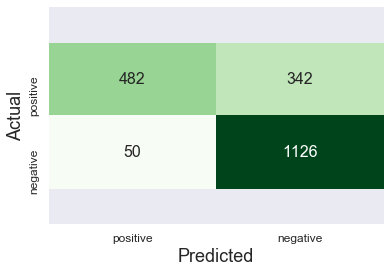

In [276]:
Y_hotel_pred = cafe_reg.predict(Hotel)

# Confusion matrix for the Hotel dataset
cm = confusion_matrix(Y_hotelTest, Y_hotel_pred)
print(classification_report(Y_hotelTest, Y_hotel_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



#### Evaluate Restaurant on the model built on Cafe

              precision    recall  f1-score   support

    positive       0.92      0.57      0.70       838
    negative       0.76      0.97      0.85      1162

    accuracy                           0.80      2000
   macro avg       0.84      0.77      0.78      2000
weighted avg       0.83      0.80      0.79      2000



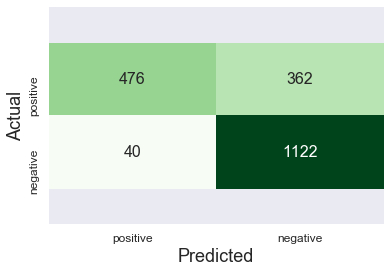

In [277]:
Y_res_pred = cafe_reg.predict(Res)

# Confusion matrix for the Restaurant dataset
cm = confusion_matrix(Y_resTest, Y_res_pred)
print(classification_report(Y_resTest, Y_res_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# Assign labels to X and Y axis.
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


#### Train a classification model on the data from  Restaurant category

In [285]:
# Splitting the dataset in training and testing dataset.

X_hotelTrain, X_hotelTest, Y_hotelTrain, Y_hotelTest = train_test_split(hotelRevdf.iloc[:,:-1], hotelRevdf.iloc[:,-1], test_size = 0.3)

# Logistic Regression Classifier.
hotel_reg = LogisticRegression()

# Fitting the model
hotel_reg.fit(X_hotelTrain, Y_hotelTrain)


Y_cafeTest = cafeRevdf.iloc[:,-1]
Y_resTest = resRevdf.iloc[:,-1]

#### Reshaping both Restaurant and Cafe dataset as per the Hotel dataset

In [286]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.5,min_df=0.01,stop_words='english',use_idf=True)

Hotel = tfidf_vectorizer.fit_transform(hotel_df['Reviews'])
print(Hotel.shape)

Cafe = tfidf_vectorizer.transform(cafe_df['Reviews'])
print(Cafe.shape)

Res = tfidf_vectorizer.transform(res_df['Reviews'])
print(Res.shape)

(2000, 1002)
(2000, 1002)
(2000, 1002)


#### Evaluate Cafe on the model built on Hotels

              precision    recall  f1-score   support

    positive       0.79      0.60      0.68       538
    negative       0.87      0.94      0.90      1462

    accuracy                           0.85      2000
   macro avg       0.83      0.77      0.79      2000
weighted avg       0.85      0.85      0.84      2000



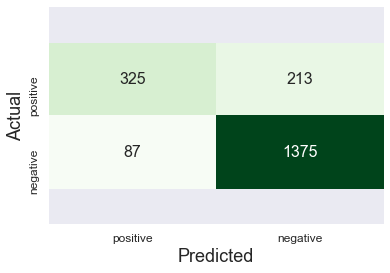

In [287]:

Y_cafe_pred = hotel_reg.predict(Cafe)

# Confusion matrix for the Cafe dataset
cm = confusion_matrix(Y_cafeTest, Y_cafe_pred)
print(classification_report(Y_cafeTest, Y_cafe_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()




#### Evaluate Restaurant on the model built on Hotels

              precision    recall  f1-score   support

    positive       0.85      0.66      0.74       838
    negative       0.79      0.92      0.85      1162

    accuracy                           0.81      2000
   macro avg       0.82      0.79      0.80      2000
weighted avg       0.82      0.81      0.81      2000



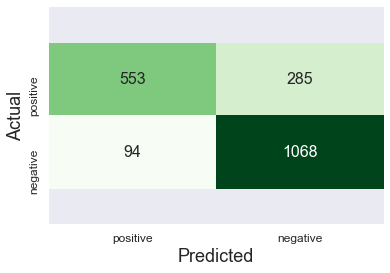

In [288]:
Y_res_pred = hotel_reg.predict(Res)

# Confusion matrix for the Restaurant dataset
cm = confusion_matrix(Y_resTest, Y_res_pred)
print(classification_report(Y_resTest, Y_res_pred, target_names=["positive","negative"]))
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Greens')
sn.set(font_scale= 1.5)
# Align the text in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)
#xaxis ticks
ax.xaxis.set_ticklabels(["positive","negative"], fontsize=12)
#yaxis ticks
ax.yaxis.set_ticklabels(["positive","negative"], fontsize=12)
# Assign labels to X and Y axis.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Conclusion for Task 3

The accuracy for the following categories are discussed below:

1. Restaurant model on 
a. Cafe dataset: The accuracy for the cafe dataset predicted on the Logistic regression model for restaurant dataset is 87%.  
b. Hotel dataset: The accuracy for the hotel dataset predicted on the Logistic regression model for restaurant dataset is 83%.   
2. Cafe model on
a. Hotel dataset: The accuracy for the hotel dataset predicted on the Logistic regression model for restaurant dataset is 80%.
b. Restaurant dataset: The accuracy for the hotel dataset predicted on the Logistic regression model for restaurant dataset is 80%.

3. Hotel model on
a. Cafe dataset: The accuracy for the hotel dataset predicted on the Logistic regression model for restaurant dataset is 85% 
b. Restaurant dataset: The accuracy for the hotel dataset predicted on the Logistic regression model for restaurant dataset is 81%.

We can conclude from the above information is that all three models ran quite well on each other clearly illustrating that sentiments of consumer reviews or the words used in review comments of similar categories are similar and hence we got high accuracies.